In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
#Prepocesamiento y normalizacion de datos
from sklearn.preprocessing import StandardScaler
# divicion de los datos en train test
from sklearn.model_selection import train_test_split
# Analisis de componentes principales
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
# EStimadores
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
#Modelos Logisticos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
# Medicion de efectividad de modelo
from sklearn.metrics import accuracy_score

In [90]:
import warnings
warnings.filterwarnings("ignore")

# Seleccion de Variables

In [91]:
dataset = pd.read_csv("dataML.csv")
dataset = dataset.drop(columns = "Unnamed: 0" ) 

Divicion Columnas

In [92]:
dataFeatures = dataset.drop(columns="Churn Value")
dataTarget = dataset["Churn Value"]

# Escalamiento de datos: 

In [93]:
scaler = StandardScaler()
dataScaled = scaler.fit_transform(dataFeatures)
dataScaled=  pd.DataFrame(dataScaled, columns= dataFeatures.columns)
dataScaled.head(2)

,Tenure Months,Monthly Charges,Total Charges,Churn Score,CLTV,Senior Citizen_Yes,Gender_Male,Partner_Yes,Dependents_Yes,Phone Service_Yes,...,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction,Churn Reason_cliente_activo
0,-1.239504,-0.363923,-0.959649,1.267300,-0.983181,-0.440327,0.990658,-0.965608,-0.547115,0.327189,...,-0.079351,-0.079351,-0.087145,-0.121922,-0.05205,-0.053406,-0.118883,-0.12132,-0.11322,-1.662059
1,-1.239504,0.196178,-0.940457,0.384802,-1.438215,-0.440327,-1.009430,-0.965608,1.827769,0.327189,...,-0.079351,-0.079351,11.475158,-0.121922,-0.05205,-0.053406,-0.118883,-0.12132,-0.11322,-1.662059


Division datos test y entranamiento

In [94]:
X_train , X_test , y_train , y_test = train_test_split(dataFeatures , dataTarget , test_size= 20, random_state= 42)

# Analisis de Componentes Principales

PCA

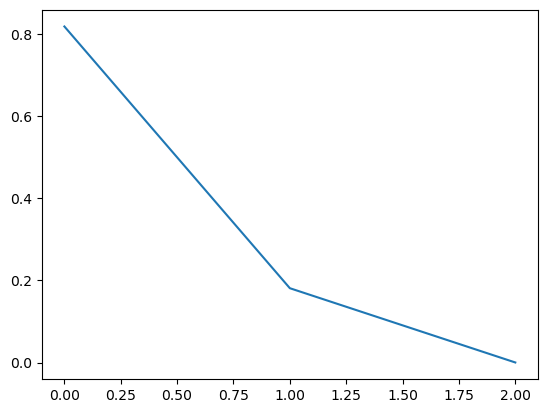

In [95]:
pca = PCA(n_components=3 ).fit(X_train)
plt.plot(range(len(pca.explained_variance_)) ,pca.explained_variance_ratio_)

In [96]:
Xpca_train = pca.transform(X_train)
Xpca_test =  pca.transform(X_test)

logistic =  LogisticRegression(
    solver = 'lbfgs').fit(
        Xpca_train, y_train)
print("SCORE PCA: ", logistic.score(Xpca_test, y_test))

SCORE PCA:  0.95


IPCA

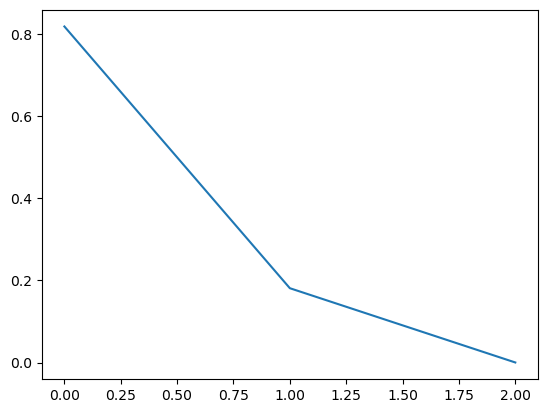

In [97]:
ipca = IncrementalPCA( n_components=3 , batch_size= 10).fit(X_train)
plt.plot(range(len(ipca.explained_variance_)),ipca.explained_variance_ratio_)

In [98]:
Xipca_train = ipca.transform(X_train)
Xipca_test =  ipca.transform(X_test)

logistic =  LogisticRegression(
    solver = 'lbfgs').fit(
        Xipca_train, y_train)
        
print("SCORE IPCA: ", logistic.score(Xipca_test, y_test))

SCORE IPCA:  0.95


Kernel PCA

In [99]:
kpca = KernelPCA(n_components=5 , kernel='poly').fit(X_train)
logistic =  LogisticRegression(solver = 'lbfgs')
kpca_train = kpca.transform(X_train)
kpca_test =  kpca.transform(X_test)
logistic.fit(kpca_train, y_train)
print("SCORE KernelPCA: ", logistic.score(kpca_test, y_test))

SCORE KernelPCA:  0.65


Notamos que tanto pca como ipca tienen buen score, dado que la variable que intentamos predicir tiene comportamiento lineal con otras. por el contrario el kernel para datos no lineales no es optimo para este modelo.

Usaremos Ipca dado que el set de datos es pequeño y tienen un buen desempeño.

# Ensambladores :

Baggin

In [100]:
modelos = (
LogisticRegression(solver = "lbfgs", max_iter = 1000), 
DecisionTreeClassifier(),
KNeighborsClassifier(),
RandomForestClassifier(),
LinearSVC(),
SVC(),
SGDClassifier())

In [101]:
def estimadores_baggin(clasificadores):
    for clasificador in clasificadores:
        modelo = BaggingClassifier(
            base_estimator= clasificador , n_estimators= 15).fit(
            Xipca_train,y_train)
        modelo_predict = modelo.predict(Xipca_test)
        print(f"""
        Clasificador: " {clasificador} 
        N_estamaciones: " {modelo.n_estimators}
        Presición_Predicción : {accuracy_score(modelo_predict , y_test)}
        ------------------------------------------------ """)

estimadores_baggin(modelos)


        Clasificador: " LogisticRegression(max_iter=1000) 
        N_estamaciones: " 15
        Presición_Predicción : 0.95
        ------------------------------------------------ 

        Clasificador: " DecisionTreeClassifier() 
        N_estamaciones: " 15
        Presición_Predicción : 1.0
        ------------------------------------------------ 

        Clasificador: " KNeighborsClassifier() 
        N_estamaciones: " 15
        Presición_Predicción : 0.95
        ------------------------------------------------ 

        Clasificador: " RandomForestClassifier() 
        N_estamaciones: " 15
        Presición_Predicción : 1.0
        ------------------------------------------------ 

        Clasificador: " LinearSVC() 
        N_estamaciones: " 15
        Presición_Predicción : 0.9
        ------------------------------------------------ 

        Clasificador: " SVC() 
        N_estamaciones: " 15
        Presición_Predicción : 0.85
        ----------------------------------

Boostin

# Estimacion Parametrica 

# Score Final: